AMSE University had conducted a controlled test to see how various conditions affect the ability of a subject to solve a given problem. The aim of the study was to see if a few seemingly unrelated conditions could affect the willingness of a person to take up and solve a challenge.

For a given period a testing room was open to anyone and everyone in the campus to come in and try their luck. The only condition laid was that the participants would have to consume a drink every hour while in the room where the puzzles were kept. This drink had various concentration of 4 Solutions A, B, C and D. Solution A was sugar syrup, solution B, C and D were red, blue and green food color respectively. The different concentration of the food color would change the effective color of the drink and the sugar syrup concentration would change the taste. Participants had no clue about the actual contents of the drinks they were given. The room also had ambient white noise along with controlled level of humidity. The concentration of the four solutions along with the decibel rating of the white noise and the relative humidity has been provided in the file ‘Test_conditions.csv’. Note that between the given period rooms were kept open 24/7. So a participant could have had entered a room while conditions for Batch X were active and complete the puzzle when the conditions for next batch — Batch B was active.

The problem given to the participants were level 2 Sudoku puzzles. Numbers around the attempts and success are given in the file ‘Sudoku_attemps.csv’


Task:
1.	Perform EDA on the given data
1.	Look for how various conditions are related to the acceptance and success rate
2.	Look for other insights from the data and draw conclusions.
3.	Any format is acceptable – Graphs/Charts, heatmaps, tables and even simple sentences
2.	Use any ML technique of your choice and try to predict the possibility of successful completion of the puzzle given a certain condition.
1.	Draw conclusions


In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# libraries used for graph and visulization
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,10

# libraries used for missing value 
import missingno as msno



from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold

In [3]:
pd_attemts =pd.read_csv("Sudoku_attemps.csv")

pd_attemts.columns

Index(['Batch ID', 'Game ID', 'Tried', 'Completed'], dtype='object')

In [4]:
pd_condition =pd.read_csv("Test_conditions.csv")

In [5]:
pd_attemts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 4 columns):
Batch ID     4077 non-null object
Game ID      4077 non-null object
Tried        4077 non-null int64
Completed    4077 non-null int64
dtypes: int64(2), object(2)
memory usage: 127.5+ KB


In [6]:
# remove those column
pd_attemts =pd_attemts[pd_attemts["Completed"] <= pd_attemts["Tried"]]

In [7]:
pd_attemts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4067 entries, 0 to 4076
Data columns (total 4 columns):
Batch ID     4067 non-null object
Game ID      4067 non-null object
Tried        4067 non-null int64
Completed    4067 non-null int64
dtypes: int64(2), object(2)
memory usage: 158.9+ KB


In [8]:
pd_attemts = pd.merge(pd_attemts, pd_condition, on='Batch ID',how='left')

In [9]:
pd_final =pd_attemts.copy()

In [10]:
pd_final['Soln D Concentration'] = pd_final['Soln D Concentration'].fillna(pd_final.groupby(['Tried','Completed'])['Soln D Concentration'].transform('mean'))
pd_final['Soln A Concentration'] =pd_final['Soln A Concentration'].fillna(pd_final.groupby(['Tried','Completed'])['Soln A Concentration'].transform('mean'))
pd_final['Relative Humidity'] = pd_final['Relative Humidity'].fillna(pd_final.groupby(['Tried','Completed'])['Relative Humidity'].transform('mean'))
pd_final['Soln B Concentration'] =pd_final['Soln B Concentration'].fillna(pd_final.groupby(['Tried','Completed'])['Soln B Concentration'].transform('mean'))
pd_final['Soln C Concentration']= pd_final['Soln C Concentration'].fillna(pd_final.groupby(['Tried','Completed'])['Soln C Concentration'].transform('mean'))

In [11]:
pd_final['White Noise (db)'] = pd_final['White Noise (db)'].fillna(pd_final.groupby(['Tried','Completed'])['White Noise (db)'].transform('mean'))

In [12]:
pd_final['Game ID'] = pd_final['Game ID'].str.replace(r'\D', '').astype(int)

In [13]:
pd_final.drop(['Batch ID'], axis=1,inplace=True)

In [14]:
pd_final=pd_final.dropna()
pd_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4058 entries, 0 to 4066
Data columns (total 9 columns):
Game ID                 4058 non-null int32
Tried                   4058 non-null int64
Completed               4058 non-null int64
Soln D Concentration    4058 non-null float64
Soln A Concentration    4058 non-null float64
Relative Humidity       4058 non-null float64
White Noise (db)        4058 non-null float64
Soln B Concentration    4058 non-null float64
Soln C Concentration    4058 non-null float64
dtypes: float64(6), int32(1), int64(2)
memory usage: 301.2 KB


In [15]:
def wrangle_game_phase(x):
    if x > 0:
        return 1
    else:
        return 0

pd_final['Completed'] = pd_final['Completed'].apply(wrangle_game_phase)

In [16]:
pd_final.Completed.unique()

array([0, 1], dtype=int64)

In [17]:
pd_feature_selection =pd_final.copy()

Text(17.75, 0.5, 'Completed')

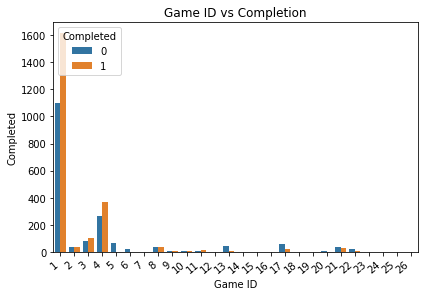

In [18]:
ax =sns.countplot(data=pd_feature_selection,hue='Completed',x='Game ID')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Game ID vs Completion')
plt.xlabel('Soln D Concentration',)
plt.ylabel('Completed')

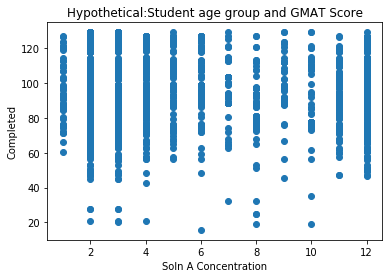

In [47]:
# Draw the scatter plot

plt.scatter( pd_feature_selection["Tried"],pd_feature_selection["Soln A Concentration"])

plt.title('Hypothetical:Student age group and GMAT Score')

plt.xlabel('Soln A Concentration')

plt.ylabel('Completed')

plt.show()

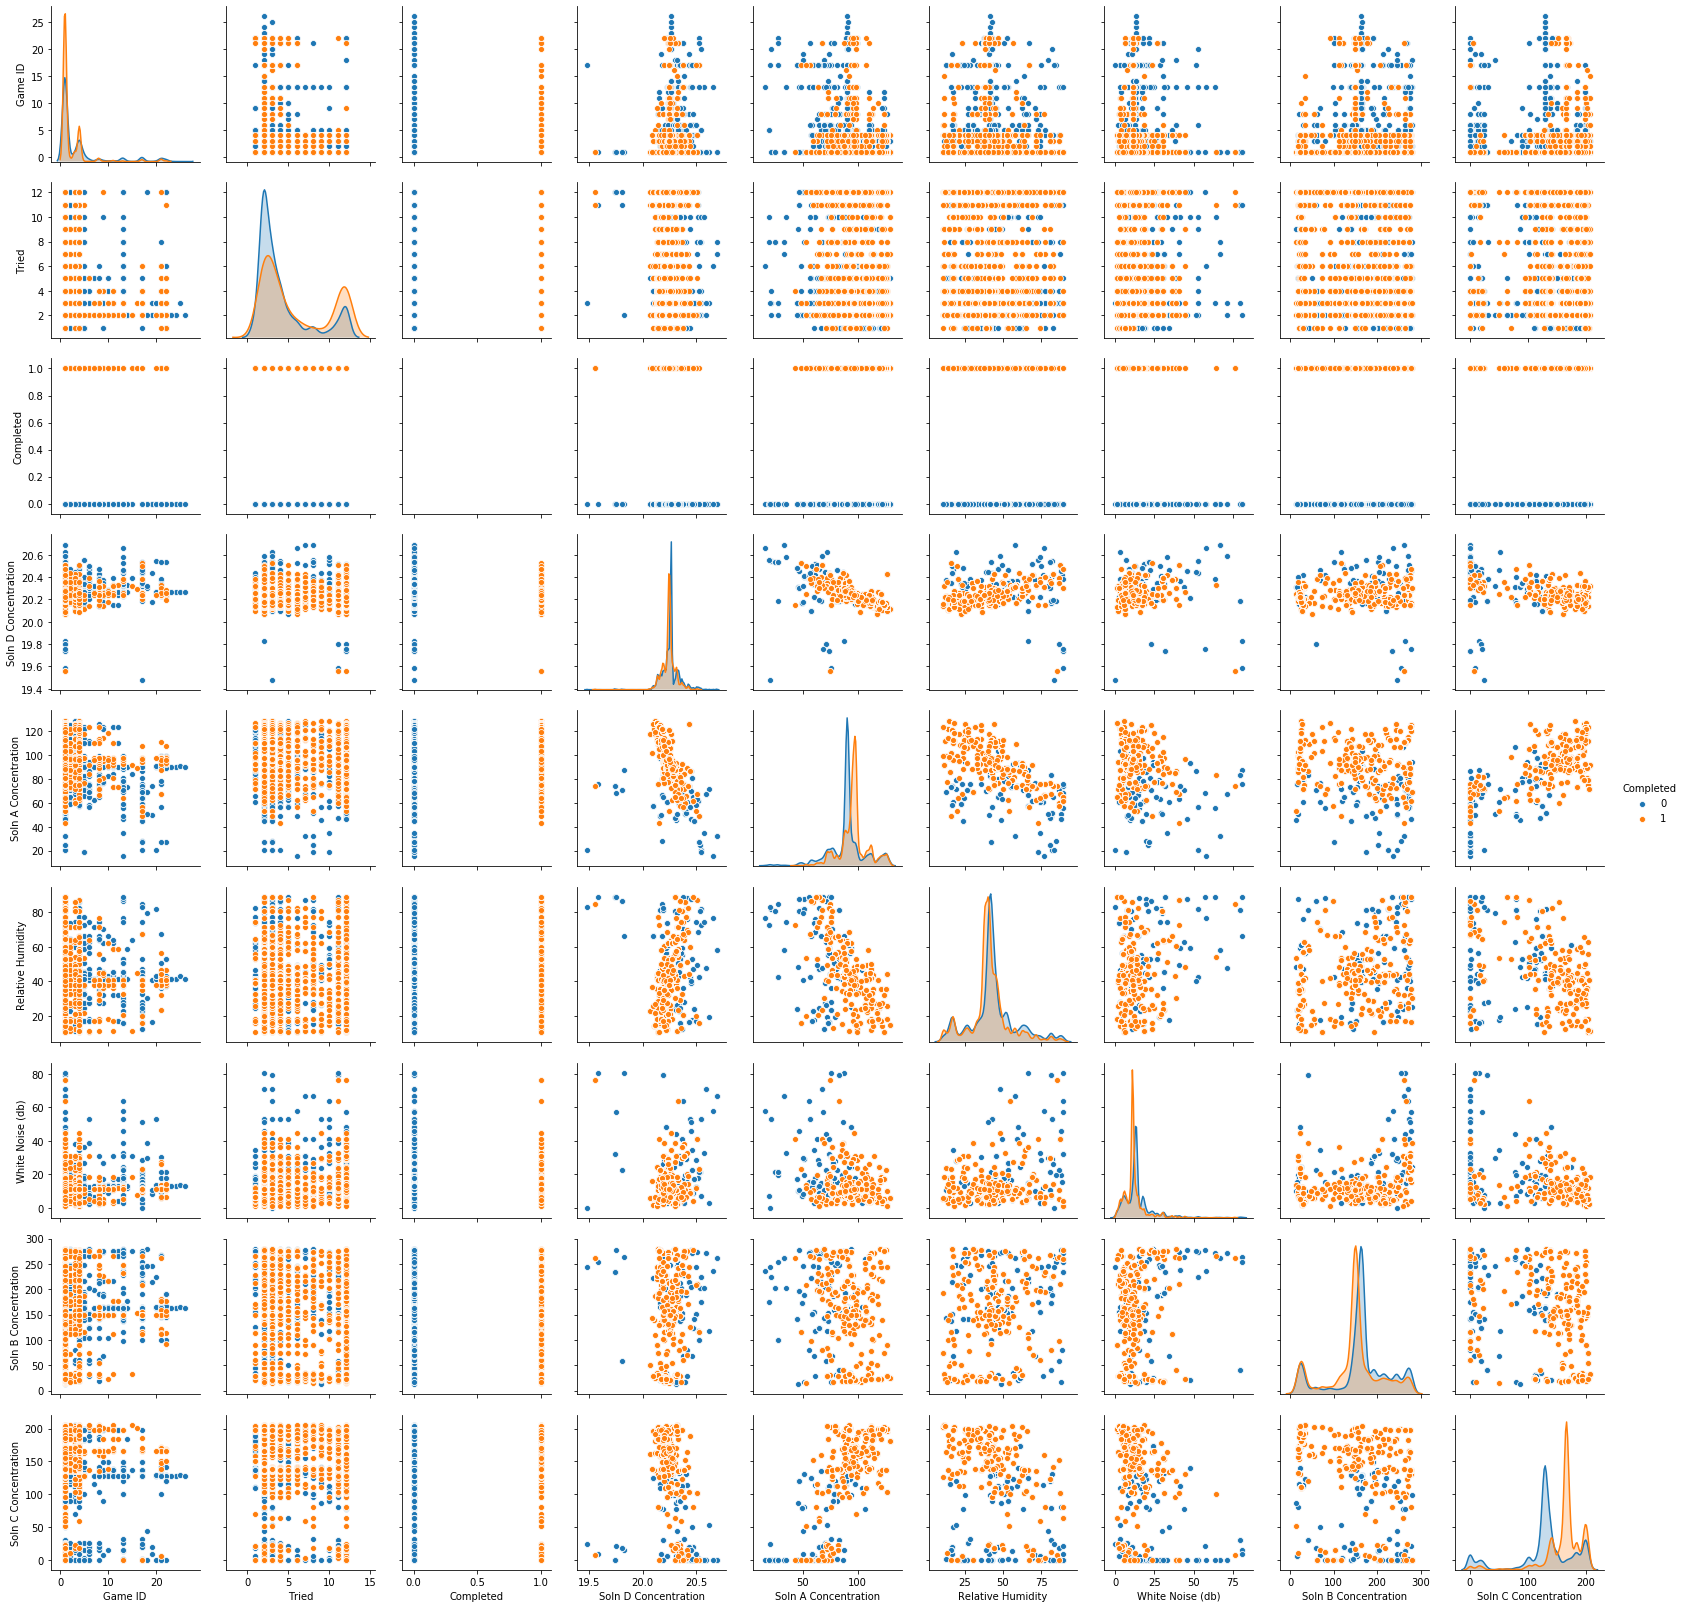

In [19]:
sns.pairplot(pd_feature_selection,hue ="Completed")

how various conditions affect the ability of a subject to solve a given problem. as we can see few seemingly unrelated conditions could affect the willingness of a person to take up and solve the problem 
like how the data is distributed for the Soln A Concentration and Soln D Concentration

So the data point are well seprated .

### Feature Selection and machine learning model building

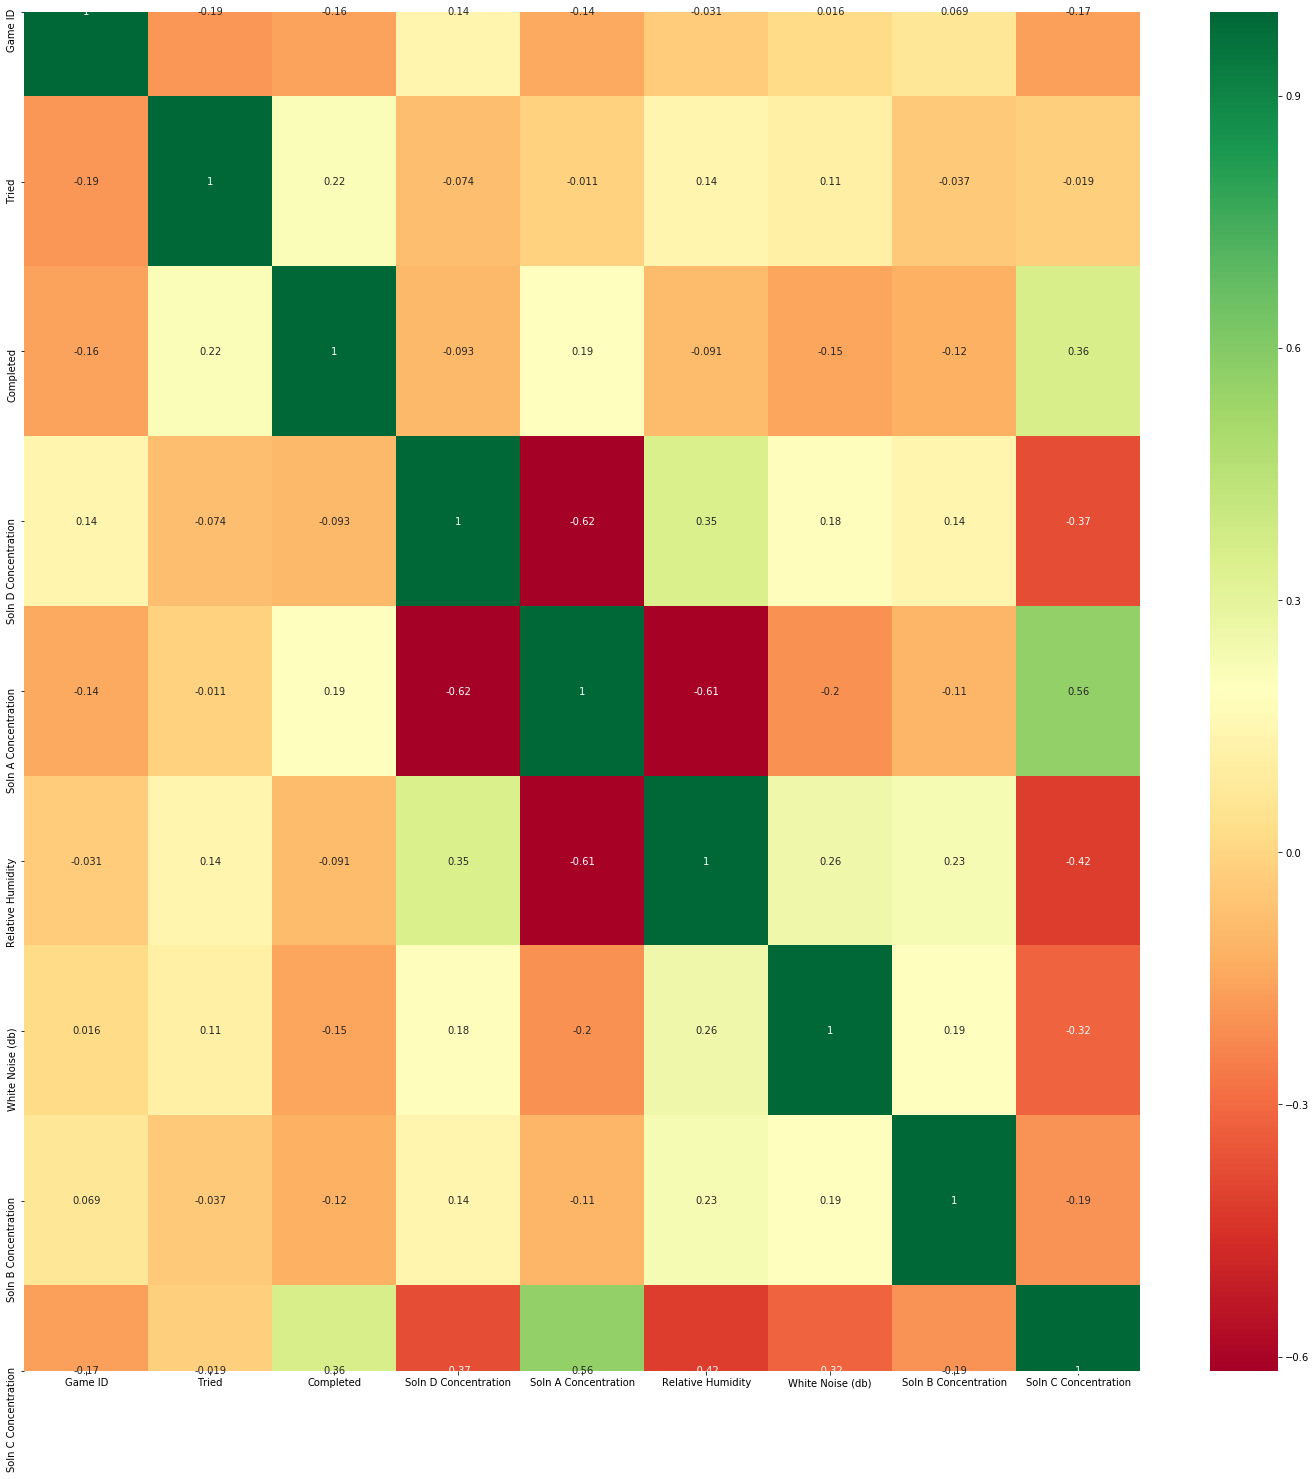

In [20]:
corrmat = pd_feature_selection.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map
g=sns.heatmap(pd_feature_selection[top_corr_features].corr(),annot=True,cmap="RdYlGn")

So we can see some of them have postive and negative correclation with the unrellated  few seemingly unrelated conditions could affect the willingness of a person to take up and solve the problem 

In [21]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# Original Data
X = pd_feature_selection.loc[:, pd_feature_selection.columns != "Completed"].values
y = pd_feature_selection.loc[:, pd_feature_selection.columns == "Completed"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=43, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((3246, 8), (812, 8))


In [22]:
pd_feature_selection['Completed'].value_counts() / pd_feature_selection.shape[0]

1    0.553721
0    0.446279
Name: Completed, dtype: float64

In [23]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [24]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500,
                                criterion="entropy", class_weight="balanced")
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring="roc_auc", cv=100)

print(f"Random forest model's average AUC: {scores.mean():.3f}")

Random forest model's average AUC: 0.936


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, precision_recall_curve, f1_score

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 233, 266, 300, 333, 366, 400, 433, 466, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [27]:
rf_random.best_estimator_.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       362
           1       0.83      0.88      0.85       450

    accuracy                           0.83       812
   macro avg       0.83      0.83      0.83       812
weighted avg       0.83      0.83      0.83       812



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18c1b6663c8>)

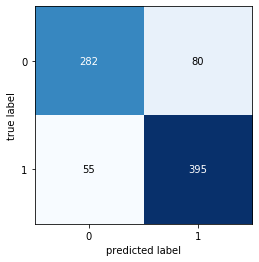

In [28]:
pred_r =rf_random.best_estimator_.predict(X_test)
print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, pred_r))

[0.02238108 0.10664897 0.10554126 0.14470105 0.08214924 0.11761259
 0.15543469 0.26553111]


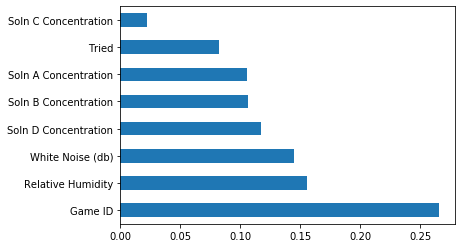

In [29]:
# fit RF to plot feature importances
rf_random.best_estimator_.fit(RobustScaler().fit_transform(X_train), y_train)

# Plot features importance
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(rf_random.best_estimator_.feature_importances_)[::-1]
print(rf_random.best_estimator_.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_random.best_estimator_.feature_importances_, index=pd_feature_selection.columns[pd_feature_selection.columns != "Completed"][indices],)
feat_importances.nlargest(47).plot(kind='barh')
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier

In [31]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
random_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

xg_model = make_pipeline(RobustScaler(), 
                    RandomizedSearchCV(XGBClassifier(objective="binary:logistic",learning_rate=0.03), 
                    param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1))




xg_model.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.0s finished


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=5, error_score=nan,
                                    estimator=XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
                                                            learning_rate=0.03,
                                                            max_delta_ste...
                                                            objective='binary:logist

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       362
           1       0.82      0.89      0.85       450

    accuracy                           0.83       812
   macro avg       0.83      0.82      0.83       812
weighted avg       0.83      0.83      0.83       812



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18c1b7972c8>)

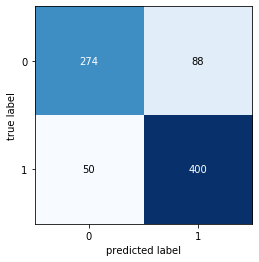

In [32]:
pred_r =xg_model.predict(X_test)
print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, pred_r))

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve

model_ml = MLPClassifier(solver = 'adam', alpha = 1e-5,activation='tanh', hidden_layer_sizes = (40,10,5), random_state = 42)
model_ml.fit(X_train, y_train)
pred_ml = model_ml.predict(X_test)

In [35]:
pred_ml_proba = model_ml.predict_proba(X_test)[:,1]
pred_r =model_ml.predict(X_test)

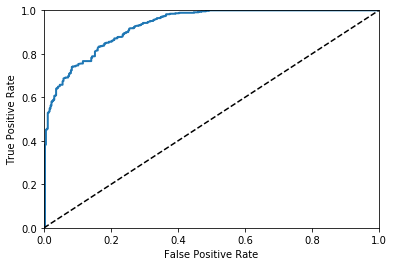

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, (pred_ml_proba))
plot_roc_curve(fpr, tpr)
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       362
           1       0.81      0.92      0.86       450

    accuracy                           0.83       812
   macro avg       0.84      0.82      0.83       812
weighted avg       0.84      0.83      0.83       812



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18c1b865988>)

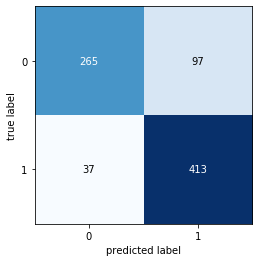

In [37]:
print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, pred_r))

In [38]:
models = {"xgb": xg_model,
          "rf": rf_random.best_estimator_,
          "netual network": model_ml}

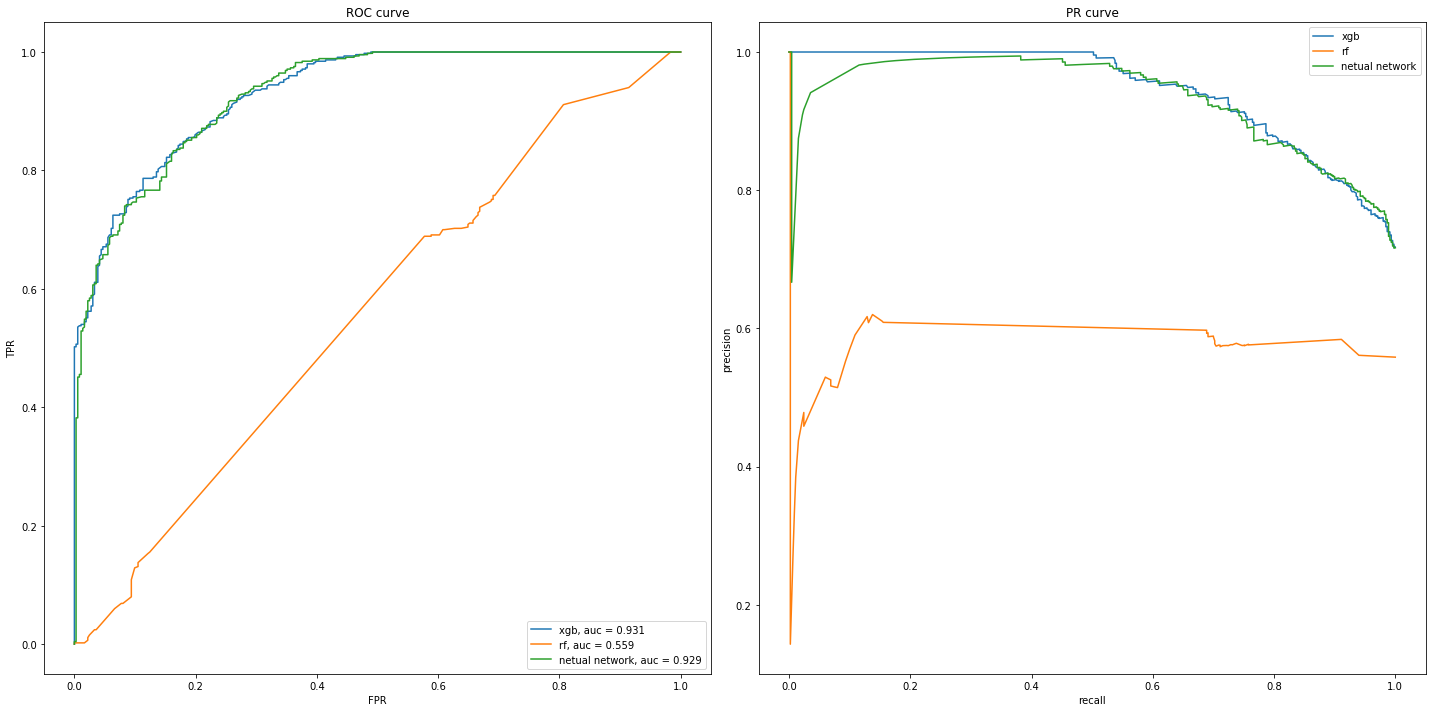

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, precision_recall_curve, f1_score

# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for name, model in models.items():    
    model_probs = model.predict_proba(X_test)[:, 1:]
    model_auc_score = roc_auc_score(y_test, model_probs)
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    axes[1].plot(recall, precision, label=f"{name}")
    
    y_pred = np.argmax(model_probs, axis=1)
    



axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()
   

So based on EDA user who are playing Game ID 1,2,3,4,5 having more chance to complete the game we can use xg_model for doing ML technique of your choice and try to predict the possibility of successful completion of the puzzle given a certain condition

In [40]:
x= pd.Series([[0,1,2,20.466,60.540,17.546,34.521,68.004,49.558]])

In [41]:
x_test_value = [  1.    ,       2.    ,      20.26571646 , 90.41630183,  41.46723476,
  13.26308841, 163.90217988, 128.42983537]
print(x_test_value)

[1.0, 2.0, 20.26571646, 90.41630183, 41.46723476, 13.26308841, 163.90217988, 128.42983537]


In [42]:
pre =xg_model.predict([x_test_value])

In [43]:
pre

array([0], dtype=int64)